In [347]:
import os
import numpy as np
import re

In [348]:
class scan:
     def __init__(self):
        self.ID = "" 
        self.annealed = False
        self.reflection = "004"
        self.omega = []
        self.intensity = []
        self.fitted = fitted()

class fitted:
    def __init__(self):
        self.A = 0
        self.B = 0
        self.rho = 0
        self.f = 0

Here I just import all files as a list of structs (or classes, whatever)

In [349]:
projections_path = "Data/Projection_SiGePeak/"

regex = r"\d{5}"

scans = []

for fileID in os.listdir(projections_path):
    file = os.fsdecode(fileID)
    file = projections_path + file
    temp = scan()

    temp.ID = (re.findall(r'(?<!\d)(\d{5})(?!\d)', file))[0]

    if temp.ID == None:
        print("Sample ID is not known!")
        exit(1)

    if "annealed" in file:
        temp.annealed = True
    elif "as_grown":
        temp.annealed = False
    else:
        print("Error, not a known annealing state!")
        exit(1)

    if "004" in file:
        temp.reflection = "004"
    elif "224" in file:
         temp.reflection = "224"
    else:
        print("Error, not a known reflection!")
        exit(1)
    
    temp.omega, _, _, _, _, _, _, _, _, temp.intensity = np.genfromtxt(file, dtype=float, skip_header=7, unpack=True)

    scans.append(temp)


dictionary = {"11352" : "580C", "11354" : "520C", "11358" : "530C", "11355" : "550C","11371" : "510C"}
scans.sort(key=lambda x: dictionary[x.ID])



In [350]:
def shift_peak(scan):
    peak_el = scan.intensity.argmax()
    delta_omega = scan.omega - scan.omega[peak_el]
    scan.omega = delta_omega
    return scan

def normalize_intensity(scan):
    intensity_max = scan.intensity.max()
    scan.intensity = scan.intensity/intensity_max
    return scan

for scan in scans:
    if scan.ID == "11358":  # ID for 530C
        peak_el = scan.intensity.argmax()
        delta_omega = scan.omega - scan.omega[peak_el]
        scan.omega = delta_omega
        scan.omega = - scan.omega
        break
    

Text(0.5, 1.0, '004, Aligned Peaks, Normalized Intensities')

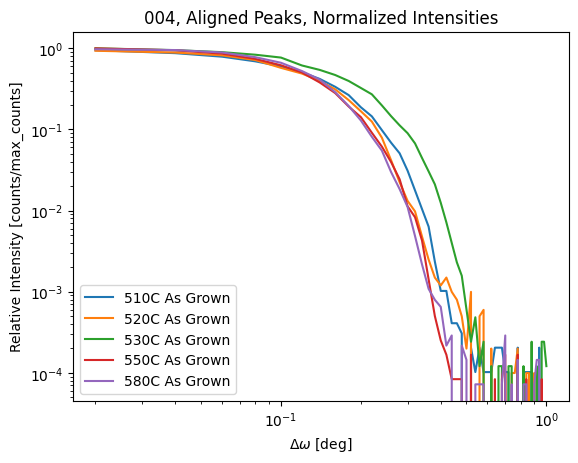

In [351]:
import matplotlib.pyplot as plt
from copy import deepcopy



for scan in scans:
    if scan.reflection == "004" and not scan.annealed:
        t = deepcopy(scan) # SUPER ugly but works
        t = shift_peak(t)
        t = normalize_intensity(t)
        plt.loglog(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.legend()
plt.xlabel(r"$\Delta\omega$ [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("004, Aligned Peaks, Normalized Intensities")


Text(0.5, 1.0, '004, Aligned Peaks, Normalized Intensities')

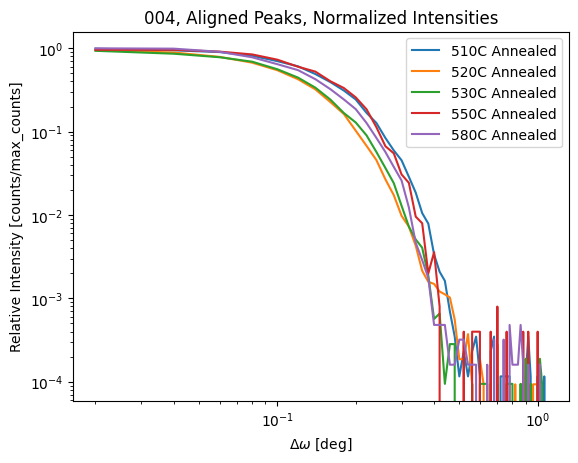

In [352]:
for scan in scans:
    if scan.reflection == "004" and scan.annealed:
        t = deepcopy(scan) # SUPER ugly but works
        t = shift_peak(t)
        t = normalize_intensity(t)
        plt.loglog(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.legend()
plt.xlabel(r"$\Delta\omega$ [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("004, Aligned Peaks, Normalized Intensities")


A =  1.8036563054399905e-07 b =  10.105248035277254
A =  1.0164792092847104 b =  -0.02960615882911441 sigma = 0.12625817527693334
004


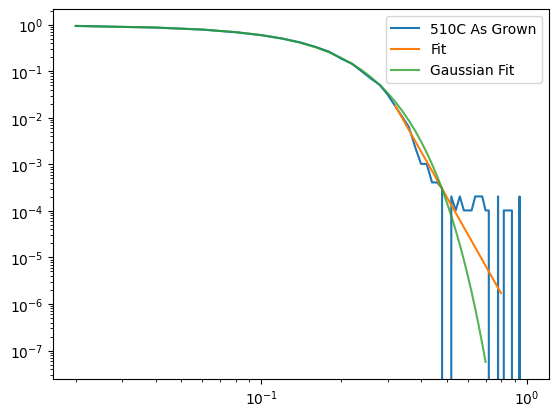

In [353]:
from scipy.optimize import curve_fit

for scan in scans:
    if scan.reflection == "004" and scan.annealed == False and scan.ID == "11371":
        t = deepcopy(scan)
t = shift_peak(t)
t = normalize_intensity(t)
f = lambda x,A,b: A* pow(x,-b)
set =(t.omega > 0.3) & (t.omega < 0.8)

gaussian = lambda x,A,b,c: A*np.exp(-pow(x-b,2)/(2*pow(c,2)))
setg = (t.omega > 0) & (t.omega < 0.7)

popvg, pcovg = curve_fit(gaussian, t.omega[setg], t.intensity[setg])
popv, pcov = curve_fit(f, t.omega[set], t.intensity[set])

plt.plot(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.plot(t.omega[set], f(t.omega[set], *popv), label = "Fit")
plt.plot(t.omega[setg], gaussian(t.omega[setg], *popvg), label = "Gaussian Fit", alpha = 0.8)

plt.legend()

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

print("A = ", popv[0], "b = ", popv[1])
print("A = ", popvg[0], "b = ", popvg[1], "sigma =", popvg[2])
print(t.reflection)

A =  9.65467962283332e-09 b =  11.503925501070754
A =  0.9727789351600217 b =  0.020932971039466213 sigma = 0.08951661561655383


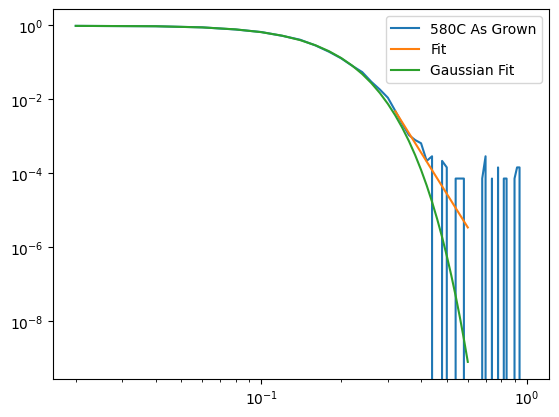

In [354]:
from scipy.optimize import curve_fit

for scan in scans:
    if scan.reflection == "004" and scan.annealed == False and scan.ID == "11352":
        t = deepcopy(scan)
t = shift_peak(t)
t = normalize_intensity(t)
f = lambda x,A,b: A* pow(x,-b)
set =(t.omega > 0.3) & (t.omega < 0.6)

gaussian = lambda x,A,b,c: A*np.exp(-pow(x-b,2)/(2*pow(c,2)))
setg = (t.omega > 0) & (t.omega < 0.6)

popvg, pcovg = curve_fit(gaussian, t.omega[setg], t.intensity[setg])
popv, pcov = curve_fit(f, t.omega[set], t.intensity[set])

plt.plot(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.plot(t.omega[set], f(t.omega[set], *popv), label = "Fit")
plt.plot(t.omega[setg], gaussian(t.omega[setg], *popvg), label = "Gaussian Fit")

plt.legend()

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

print("A = ", popv[0], "b = ", popv[1])
print("A = ", popvg[0], "b = ", popvg[1], "sigma =", popvg[2])

# 224

Text(0.5, 1.0, '224, Aligned Peaks, Normalized Intensities')

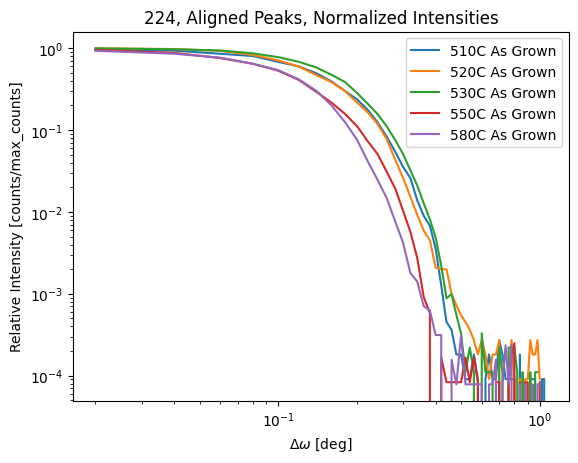

In [355]:
omega = np.linspace(0.2, 0.4, 10)

for scan in scans:
    if scan.reflection == "224" and not scan.annealed:
        t = deepcopy(scan)
        t = shift_peak(t)
        t = normalize_intensity(t)
        plt.loglog(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.legend()
plt.xlabel(r"$\Delta\omega$ [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("224, Aligned Peaks, Normalized Intensities")


Text(0.5, 1.0, '224, Aligned Peaks, Normalized Intensities')

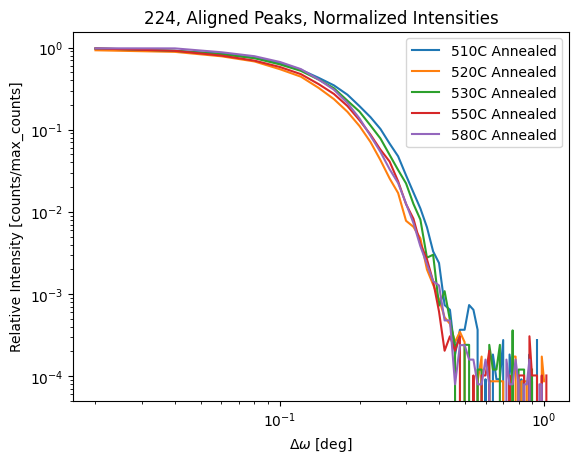

In [356]:
for scan in scans:
    if scan.reflection == "224" and scan.annealed:
        t = deepcopy(scan)
        t = shift_peak(t)
        t = normalize_intensity(t)
        if scan.ID == "11358": t.omega = -t.omega
        if scan.ID == "11371": t.omega = -t.omega
        if scan.ID == "11352": t.omega = -t.omega
        plt.loglog(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.legend()
plt.xlabel(r"$\Delta\omega$ [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("224, Aligned Peaks, Normalized Intensities")


A =  3.73066787965097e-06 b =  7.646568828721239
A =  0.9877167268406488 b =  0.001636892843127545 sigma = 0.1169150551850334
224


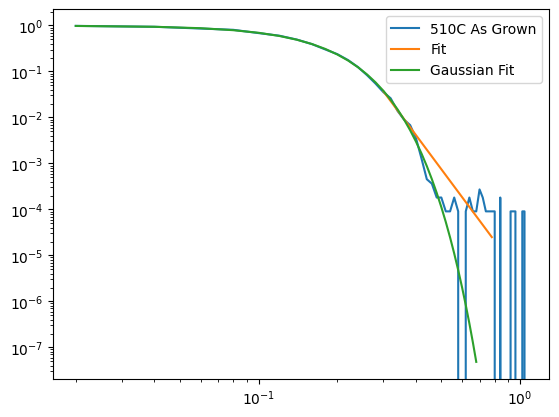

In [357]:
from scipy.optimize import curve_fit
for scan in scans:
    if scan.reflection == "224" and scan.annealed == False and scan.ID == "11371":
        t = deepcopy(scan)

t = shift_peak(t)
t = normalize_intensity(t)
f = lambda x,A,b: A* pow(x,-b)
set =(t.omega > 0.3) & (t.omega < 0.8)

gaussian = lambda x,A,b,c: A*np.exp(-pow(x-b,2)/(2*pow(c,2)))
setg = (t.omega > 0) & (t.omega < 0.7)

popvg, pcovg = curve_fit(gaussian, t.omega[setg], t.intensity[setg])
popv, pcov = curve_fit(f, t.omega[set], t.intensity[set])

plt.plot(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.plot(t.omega[set], f(t.omega[set], *popv), label = "Fit")
plt.plot(t.omega[setg], gaussian(t.omega[setg], *popvg), label = "Gaussian Fit")

plt.legend()

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

print("A = ", popv[0], "b = ", popv[1])
print("A = ", popvg[0], "b = ", popvg[1], "sigma =", popvg[2])
print(t.reflection)

A =  4.70566970155827e-08 b =  9.444286304008632
A =  0.9342543212528241 b =  0.005853956070472079 sigma = 0.08827807850431425
224


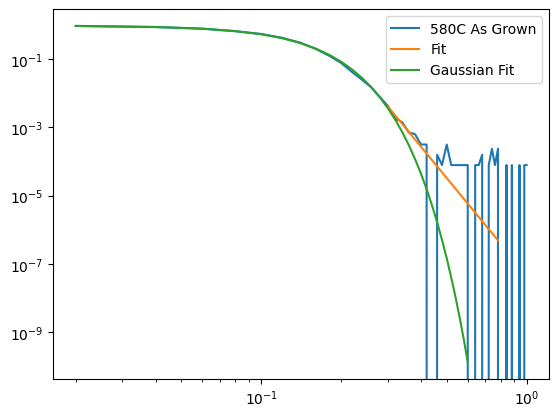

In [358]:
from scipy.optimize import curve_fit
for scan in scans:
    if scan.reflection == "224" and scan.annealed == False and scan.ID == "11352":
        t = deepcopy(scan)

t = shift_peak(t)
t = normalize_intensity(t)
f = lambda x,A,b: A* pow(x,-b)
set =(t.omega > 0.3) & (t.omega < 0.8)

gaussian = lambda x,A,b,c: A*np.exp(-pow(x-b,2)/(2*pow(c,2)))
setg = (t.omega > 0) & (t.omega < 0.6)

popvg, pcovg = curve_fit(gaussian, t.omega[setg], t.intensity[setg])
popv, pcov = curve_fit(f, t.omega[set], t.intensity[set])

plt.plot(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.plot(t.omega[set], f(t.omega[set], *popv), label = "Fit")
plt.plot(t.omega[setg], gaussian(t.omega[setg], *popvg), label = "Gaussian Fit")

plt.legend()

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

print("A = ", popv[0], "b = ", popv[1])
print("A = ", popvg[0], "b = ", popvg[1], "sigma =", popvg[2])
print(t.reflection)